In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip pchdata.zip -d /content/
!find /content/pchdata -type d -empty -delete

In [103]:
class P1aSet(Dataset):
    def __init__(self, root):
        self.root = root
        self.folders = sorted(os.listdir(self.root))
    
    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        with open(os.path.join(self.root, self.folders[idx], "GT.json"), "r") as f:
            sim_data = json.load(f)
            pch = sim_data['Data']['pch_bins']
            tdist = sim_data['Data']['true_bins']

        return torch.tensor(pch, dtype=torch.float32), torch.tensor(tdist, dtype=torch.float32)

In [128]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        if in_channels != out_channels:
            self.projection = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.projection = None
        self.gelu = nn.GELU()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.projection:
            identity = self.projection(identity)
        out += identity
        out = self.gelu(out)
        return out

class BASCNN(nn.Module):
    def __init__(self, input_length=50, output_dim=100):
        super().__init__()
        self.resblock1 = ResidualBlock(1, 32)
        self.dropout1 = nn.Dropout(0.1)
        self.resblock2 = ResidualBlock(32, 64)
        self.dropout2 = nn.Dropout(0.1)
        self.resblock3 = ResidualBlock(64, 128)
        self.dropout3 = nn.Dropout(0.1)
        self.resblock4 = ResidualBlock(128, 256)
        self.dropout4 = nn.Dropout(0.15)

        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Linear(256 * input_length, input_length * 128),
            nn.ReLU(),
            nn.Linear(128 * input_length, 64 * input_length),
            nn.ReLU(),
            nn.Linear(64*input_length, output_dim * 20),
            nn.ReLU(),
            nn.Linear(output_dim*20, output_dim*10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
        )
        self.fc = nn.Linear(256 * input_length, output_dim)
        self.dropout = nn.Dropout(0.25)
        self.softplus = nn.Softplus()

    def forward(self, x, return_log=False):
        x = x.unsqueeze(1)  # (batch_size, 1, input_length)
        x = self.dropout1(self.resblock1(x))
        x = self.dropout2(self.resblock2(x))
        x = self.dropout3(self.resblock3(x))
        x = self.dropout4(self.resblock4(x))

        x = self.flatten(x)  # (batch_size, 256 * input_length)
        x = self.dropout(x)
        x = self.fc(x)  # (batch_size, output_dim)
        # if return_log:
        #     return F.log_softmax(x, dim=1)
        # else:
        #     return F.softmax(x, dim=1)
        return self.softplus(x)

In [129]:
lr = 2e-5
BATCH_SIZE = 32
NUM_EPOCHS = 200
model = BASCNN()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.PoissonNLLLoss(log_input=False)

dataset = P1aSet(r"/content/pchdata")

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

val_size = int(val_ratio * len(dataset))
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - val_size - test_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

In [ ]:
model.to(device)
train_losses = []
val_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss = 0.0
    val_loss = 0.0
    model.train()
    for i, (pch, tdist) in enumerate(train_loader):
        pch, tdist = pch.to(device), tdist.to(device)
        pred_dist = model(pch)
        s_p = pred_dist.sum(axis=1)
        s_t = tdist.sum(axis=1)
        loss = criterion(pred_dist, tdist)
        
        if i == 200:
            acd_mse = F.mse_loss(tdist[0], pred_dist[0])
            true_pch = pch[0].cpu().numpy()
            pred_dist = pred_dist[0].cpu().detach().numpy()
            true_dist = tdist[0].cpu().numpy()
            s_t = true_dist.sum()
            s_p = pred_dist.sum()

            
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].plot(true_pch, marker='o', label='True PCH')
            axes[0].set_title("PCH")
            axes[0].set_xlabel("Bin")
            axes[0].set_ylabel("Intensity Count (#)")
            axes[0].legend()
            axes[0].grid(True)

            axes[1].plot(true_dist, marker='o', label='True Brightness Dist')
            axes[1].plot(pred_dist, marker='x', linestyle='--', label='Predicted Brightness Dist')
            axes[1].set_title(f"Brightness | MSE: {acd_mse:.5f} | Pred Sum: {s_p:.2f} | True Sum: {s_t:.2f}")
            axes[1].set_xlabel("Bin")
            axes[1].set_ylabel("Count (#)")
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for pch, tdist in val_loader:
            pch, tdist = pch.to(device), tdist.to(device)
            pred_dist = model(pch)
            s_p = pred_dist.sum(axis=1)
            s_t = tdist.sum(axis=1)
            loss = criterion(pred_dist, tdist)
            
            val_loss += loss.item()

    current_val_loss = val_loss / len(val_loader)
    scheduler.step(current_val_loss)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping")
            break
    
    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader)} | Val: {val_loss / len(val_loader)}")
    
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

In [124]:
model.eval()
maes = []
mapes = []
rmses = []

def m_mae(pred_dist, tdist, eps=1e-6, threshold=0.3):

    mask = ~((pred_dist.abs() < threshold) & (tdist.abs() < threshold))
    
    diff = torch.abs(pred_dist - tdist)[mask]

    if diff.numel() == 0:
        return torch.tensor(0.0, device=pred_dist.device)
    
    return diff.mean()


def m_smape(pred_dist, tdist, eps=1e-8, threshold=0.3):
    mask = ~((pred_dist.abs() < threshold) & (tdist.abs() < threshold))

    # symmetric denominator: (|pred| + |true|)/2
    denom = (pred_dist.abs() + tdist.abs()).clamp(min=eps)

    diff = (torch.abs(pred_dist - tdist) / denom)[mask]

    if diff.numel() == 0:
        return torch.tensor(0.0, device=pred_dist.device)

    return diff.mean() * 100.0  

def m_rmse(pred_dist, tdist, eps=1e-6, threshold=0.3):
    mask = ~((pred_dist.abs() < threshold) & (tdist.abs() < threshold))
    
    diff = (pred_dist - tdist)[mask] ** 2
    
    if diff.numel() == 0:
        return torch.tensor(0.0, device=pred_dist.device)
    
    return torch.sqrt(diff.mean())


test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
for pch, tdist in test_loader:
  pch, tdist = pch.to(device), tdist.to(device)
  with torch.no_grad():
    pred_dist = model(pch).detach().cpu().squeeze()
  tdist = tdist.cpu().squeeze()
    
  mae = m_mae(tdist, pred_dist)
  maes.append(mae.item())

  rmse = m_rmse(tdist, pred_dist)
  rmses.append(rmse.item())

  mape = m_smape(tdist, pred_dist)
  mapes.append(mape.item())


    
  # plt.plot(tdist.numpy(), label='true dist')
  # plt.plot(pred_dist.numpy(), label='pred dist')
  # plt.legend()
  # plt.tight_layout()
  # plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
for pch, tdist in test_loader:
    pch, tdist = pch.to(device), tdist.to(device)
    with torch.no_grad():
        pred_dist = model(pch).detach().cpu().squeeze()
    true_np = tdist.cpu().squeeze().numpy()
    pred_np = pred_dist.numpy()
    distedges = np.linspace(0, 8000, 101)
    bin_centers = distedges[:-1]
    bin_widths = np.diff(distedges)
    
    labels = [f"{int(distedges[i])}-{int(distedges[i+1])}" for i in range(len(distedges)-1)]
    
    df = pd.DataFrame({
        "Amplitude Interval": labels * 2,
        "Count": np.concatenate([true_np, pred_np]),
        "Type": ["Actual"] * len(true_np) + ["Predicted"] * len(pred_np)
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Amplitude Interval",
        y="Count",
        hue="Type",
        data=df,
        palette=["skyblue", "deepskyblue"],
        dodge=True
    )
    
    plt.title("Concentrations for Different Fluorescence Intervals", fontsize=14)
    plt.xlabel("Fluorescence Intensity", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    step = 5  # show every 5 bins
    xticks = np.arange(0, len(labels), step)  # positions for ticks
    xtick_labels = [
        f"{int(distedges[i])}-{int(distedges[i+step])}" 
        for i in range(0, len(distedges)-1, step)
    ]

    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [125]:
maes = np.array(maes)
rmses = np.array(rmses)
mapes = np.array(mapes)
print(f"mae: {maes.mean()}, {maes.std()}")
print(f"rmse: {rmses.mean()}, {rmses.std()}")
print(f"mape: {mapes.mean()}, {mapes.std()}")

mae: 5.013563777883997, 6.85308003955973
rmse: 8.647824049405243, 9.612983554782515
mape: 59.31124604775218, 15.621403630476983


np.float64(8865.4970703125)

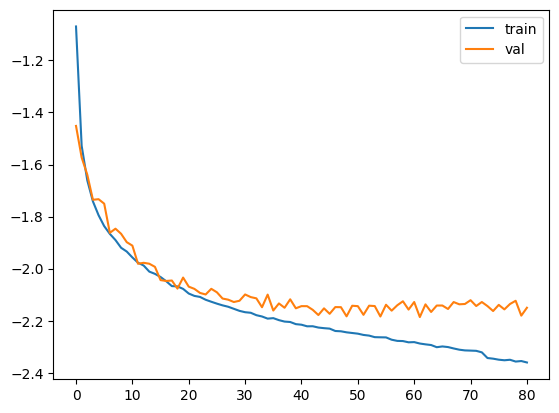

In [123]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()